In [13]:
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.linear_model import LogisticRegression

In [14]:
df_train = pd.read_csv('train.csv', index_col='PassengerId')

In [15]:
df_test = pd.read_csv('test.csv', index_col='PassengerId')

In [16]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1) Feature Engineering

In [17]:
df_train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [18]:
def feature_engineer(df):
    
    # drop columns not needed
    df.drop(columns=['Ticket','Fare','Cabin'], inplace=True)
    
    # drop rows with NaNs
    df.dropna(subset=['Embarked'], inplace=True)
    
    # extract title from names
    names = []
    for i in df['Name']:
        names.append(i.split(',')[1].split('.')[0].strip())
    df['Title'] = names 

    # normalize the titles
    normalized_titles = {
        "Capt":       "Officer",
        "Col":        "Officer",
        "Major":      "Officer",
        "Jonkheer":   "Royalty",
        "Don":        "Royalty",
        "Sir" :       "Royalty",
        "Dr":         "Officer",
        "Rev":        "Officer",
        "the Countess":"Royalty",
        "Dona":       "Royalty",
        "Mme":        "Mrs",
        "Mlle":       "Miss",
        "Ms":         "Mrs",
        "Mr" :        "Mr",
        "Mrs" :       "Mrs",
        "Miss" :      "Miss",
        "Master" :    "Master",
        "Lady" :      "Royalty"
        }
    
    # map the normalized titles to the current titles 
    df.Title = df.Title.map(normalized_titles)
    df.drop(['Name'], axis=1, inplace=True)

    # replace Age NaNs with median age based on title (stolen code)
    grouped = df.groupby(['Sex','Pclass', 'Title'])  
    df.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))
    df.drop(['Title'], axis=1, inplace=True)

    #average_age = df['Age'].mean()
    #df['Age'] = df['Age'].fillna(average_age)
    
    # turn categories into binary code
    df['Sex'] = pd.factorize(df['Sex'], sort=True)[0]
    one_hot_encoded = pd.get_dummies(df['Embarked'])
    df = pd.concat((df, one_hot_encoded), axis=1)
    df.rename(columns={"C": "C_Embarked"}, inplace=True)
    one_hot_encoded_2 = pd.get_dummies(df['Pclass'])
    df = pd.concat((df, one_hot_encoded_2), axis=1)
    df.drop(['Embarked','Pclass'], axis=1, inplace=True)
    
    # add new column for total number of family members
    df['total_family_on_board'] = df['SibSp'] + df['Parch']
    df.drop(columns=['SibSp','Parch'], axis = 1, inplace=True)
    
    # create new column for survival rate based on family members and then drop family column
    di = {3: 0.724138, 2: 0.578431, 1:0.552795, 6:0.333333, 0:0.300935, 4:0, 5:0, 7:0,10:0 }
    df['survival_rate_family'] = df['total_family_on_board'].map(di)
    df.drop(['total_family_on_board'], axis=1, inplace=True)

    # fill Cabin NaN with U for unknown
    #df.Cabin = df.Cabin.fillna('U')
    
    # map first letter of cabin to itself
    #df.Cabin = df.Cabin.map(lambda x: x[0])
    
    # turn cabin into binary code
    #one_hot_encoded_cabin = pd.get_dummies(df['Cabin'])
    #df = pd.concat((df, one_hot_encoded_cabin), axis=1)
    #df.rename(columns={"C": "C_Cabin"}, inplace=True)
    #df.drop(['Cabin'], axis=1, inplace=True)

    return df

#https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9


In [19]:
df_train = feature_engineer(df_train)

In [20]:
df_train.head(10)

,Survived,Sex,Age,C_Embarked,Q,S,1,2,3,survival_rate_family
PassengerId,,,,,,,,,,
1,0,1,22.0,0,0,1,0,0,1,0.552795
2,1,0,38.0,1,0,0,1,0,0,0.552795
3,1,0,26.0,0,0,1,0,0,1,0.300935
4,1,0,35.0,0,0,1,1,0,0,0.552795
5,0,1,35.0,0,0,1,0,0,1,0.300935
6,0,1,26.0,0,1,0,0,0,1,0.300935
7,0,1,54.0,0,0,1,1,0,0,0.300935
8,0,1,2.0,0,0,1,0,0,1,0.000000
9,1,0,27.0,0,0,1,0,0,1,0.578431


In [9]:
corr = df_train.corr()

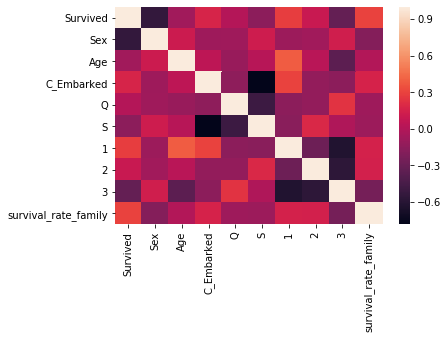

In [10]:
import seaborn as sns
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

### Splitting data set into training and test set 

In [11]:
from sklearn.model_selection import train_test_split
X = df_train[['Sex','Age','Q','S',3]]
#X = df_train[['Sex']]
y = df_train['Survived'] 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((666, 5), (223, 5), (666,), (223,))

In [14]:
X_train.head()

,Sex,Age,Q,S,3
PassengerId,,,,,
377,0,22.0,0,1,1
459,0,50.0,0,1,0
733,1,31.0,0,1,0
508,1,40.0,0,1,0
831,0,15.0,0,0,1


---------------------
#### Step 1)  Determine X features and y prediction column

In [15]:
m = LogisticRegression()

In [16]:
m.fit(X_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
m.score(X_train, y_train)

0.7942942942942943

In [18]:
a = m.coef_
a

array([[-2.33505741, -0.0225113 , -0.27786379, -0.63955233, -1.59324261]])

In [19]:
b = m.intercept_
b

array([2.94617287])

In [20]:
m.score(X_test, y_test)

0.7847533632286996

In [21]:
import statsmodels.discrete.discrete_model as sm

# H0 = My coef. is not significant.
# p< 0.05 => I can reject the H0 so my coefficient is significant.


logit = sm.Logit(y_train, X_train)
f = logit.fit()
print(f.params)
print(f.summary())

Optimization terminated successfully.
         Current function value: 0.524952
         Iterations 6
Sex   -1.993014
Age    0.021407
Q      0.716167
S      0.386081
3     -0.790569
dtype: float64
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  666
Model:                          Logit   Df Residuals:                      661
Method:                           MLE   Df Model:                            4
Date:                Thu, 10 Oct 2019   Pseudo R-squ.:                  0.2136
Time:                        12:32:32   Log-Likelihood:                -349.62
converged:                       True   LL-Null:                       -444.60
Covariance Type:            nonrobust   LLR p-value:                 5.404e-40
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Sex          

In [22]:
ypred = m.predict(X)

In [23]:
from sklearn.metrics import confusion_matrix

c = confusion_matrix(y, ypred)

In [24]:
cm = pd.DataFrame(c, index=['Actual-NO', 'Actual-YES'], columns=['Prediction-NO', 'Prediction-YES'])
cm

,Prediction-NO,Prediction-YES
Actual-NO,471,78
Actual-YES,107,233


Text(0.5, 1, 'confusion matrix for Titanic')

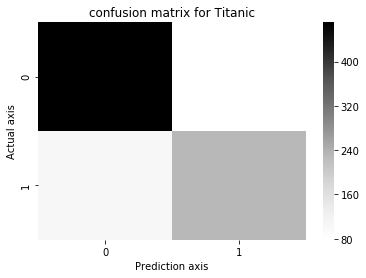

In [25]:
import seaborn as sns

sns.heatmap(c, cmap='Greys')
plt.xlabel('Prediction axis')
plt.ylabel('Actual axis')
plt.title('confusion matrix for Titanic')

In [26]:
from sklearn.metrics import precision_score, recall_score

recall_score(y, ypred), precision_score(y, ypred)

(0.6852941176470588, 0.7491961414790996)

In [27]:
m

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
from sklearn.dummy import DummyClassifier

n = DummyClassifier()
n.fit(X,y)
npred = n.predict(X)
opred = m.predict(X)

Text(0, 0.5, 'recall')

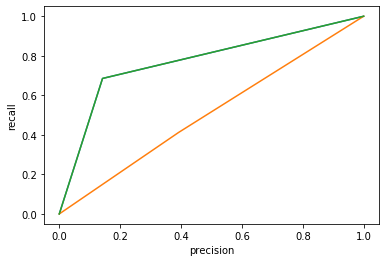

In [29]:
from sklearn.metrics import roc_curve, auc

precision, recall, threshold = roc_curve(y, ypred)
fpr, tpr, threshold = roc_curve(y,npred)
for_, tor, threshold = roc_curve(y, opred)

plt.plot(precision, recall)
plt.plot(fpr,tpr)
plt.plot(for_, tor)
plt.xlabel('precision')
plt.ylabel('recall')

______

## Kaggle Submission CSV

In [30]:
kaggle_test = pd.read_csv('test.csv')

In [31]:
kaggle_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [32]:
df_kaggle_test = feature_engineer(kaggle_test.set_index('PassengerId'))

In [33]:
df_kaggle_test.head()

,Sex,Age,C_Embarked,Q,S,1,2,3,survival_rate_family
PassengerId,,,,,,,,,
892,1,34.5,0,1,0,0,0,1,0.300935
893,0,47.0,0,0,1,0,0,1,0.552795
894,1,62.0,0,1,0,0,1,0,0.300935
895,1,27.0,0,0,1,0,0,1,0.300935
896,0,22.0,0,0,1,0,0,1,0.578431


In [1]:
predictions = m.predict(df_kaggle_test)

output = pd.DataFrame()
output['PassengerId'] = df_kaggle_test.index
output['Survived'] = predictions
output.to_csv('logistic_regression_v08.csv', index=False)

NameError: name 'm' is not defined

In [ ]:
submission = pd.read_csv('logistic_regression_v08.csv', index_col='PassengerId')

In [ ]:
submission.head()